# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_048  F8W785;O00461              15.994
Sample_003  Q8NBP7                     15.262
Sample_167  Q9Y6N6                     15.180
Sample_042  P35241;P35241-4;P35241-5   16.382
Sample_102  A2A2D0;P16949;P16949-2     16.287
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups        
Sample_131  Q9UMX5                   16.817
Sample_135  Q9UBG0                   15.275
Sample_091  H0Y512;Q9HDC9;Q9HDC9-2   11.972
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.508
            A0A075B6Q5                 12.381
            A0A075B6R2                 12.452
            A0A075B6S5                 14.006
            A0A087WSY4                 13.351
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.983
            Q9UI40;Q9UI40-2            12.846
            Q9UIW2                     12.575
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.414
            Q9UP79                     11.758
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.988,15.050,16.842,19.863,15.980,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.783,19.067,...,15.528,15.576,14.041,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.842,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.176,17.705,17.039,15.610,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.813,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.760,15.345,17.084,18.708,14.249,19.433,11.326,10.465
Sample_207,15.739,16.877,15.469,16.898,13.678,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.508,...,16.012,15.178,12.953,15.050,16.842,19.863,14.527,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.394,19.067,16.188,...,15.528,15.576,12.211,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.587,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,14.046,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.899,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.834,15.345,17.084,18.708,14.249,19.433,12.761,12.858
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.11it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.83it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.40it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.02it/s]

100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.52it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.87it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.19it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.81it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.88it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.75it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.21it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.41it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.21it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.09it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.91it/s]

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.11it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.18it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.77it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.36it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.24it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.07it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.84it/s]

100%|██████████| 9/9 [00:02<00:00,  2.91it/s]

100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.32it/s]

 30%|███       | 3/10 [00:01<00:02,  2.64it/s]

 40%|████      | 4/10 [00:01<00:02,  2.42it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.48it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.56it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.64it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.80it/s]

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.27it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.84it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.49it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.16it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.36it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.49it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.70it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.89it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.84it/s]

100%|██████████| 11/11 [00:04<00:00,  2.86it/s]

100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.13it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.60it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.89it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.59it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.83it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.43it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.20it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.25it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.33it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.41it/s]

100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.53it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.76it/s]

 31%|███       | 4/13 [00:00<00:02,  4.09it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.79it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.82it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.47it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.16it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.14it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.21it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.32it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.47it/s]

100%|██████████| 13/13 [00:04<00:00,  2.51it/s]

100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.22it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.61it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.74it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.67it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.26it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.66it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.41it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.12it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.12it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.38it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.50it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.63it/s]

100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.08it/s]

 20%|██        | 3/15 [00:00<00:02,  4.18it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.47it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.31it/s]

 40%|████      | 6/15 [00:01<00:02,  3.16it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.09it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.55it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.44it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.24it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.12it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.09it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.32it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.52it/s]

100%|██████████| 15/15 [00:05<00:00,  2.66it/s]

100%|██████████| 15/15 [00:05<00:00,  2.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.075 0.029          0.651 0.422       0.091   
2             0.005 0.003      0.068 0.024          0.700 0.118       0.516   
3             0.006 0.006      0.066 0.026          0.711 0.114       0.623   
4             0.004 0.000      0.051 0.012          0.719 0.083       0.722   
5             0.006 0.006      0.063 0.022          0.772 0.093       0.726   
6             0.007 0.005      0.077 0.027          0.779 0.082       0.751   
7             0.004 0.000      0.048 0.001          0.817 0.082       0.838   
8             0.004 0.002      0.051 0.011          0.820 0.086       0.834   
9             0.004 0.002      0.049 0.009          0.815 0.090       0.832   
10            0.004 0.002      0.052 0.012          0.808 0.093       0.807   
11            0.005 0.002      0.053 0.015          0.810 0.094       0.812   
12            0.006 0.005      0.061 0.026          0.817 0.080       0.812   
13            0.005 0.003      0.058 0.018          0.807 0.088       0.813   
14            0.005 0.004      0.063 0.020          0.803 0.089       0.807   
15            0.005 0.002      0.060 0.024          0.803 0.082       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.153 0.128                  0.538 0.039        0.854   
2          0.111   0.584 0.086                  0.672 0.059        0.722   
3          0.130   0.653 0.088                  0.713 0.069        0.788   
4          0.110   0.716 0.080                  0.756 0.066        0.833   
5          0.103   0.743 0.077                  0.782 0.062        0.850   
6          0.109   0.759 0.072                  0.796 0.059        0.849   
7          0.077   0.823 0.054                  0.848 0.046        0.902   
8          0.080   0.822 0.055                  0.847 0.046        0.900   
9          0.080   0.819 0.057                  0.844 0.049        0.900   
10         0.094   0.803 0.068                  0.831 0.057        0.899   
11         0.098   0.806 0.071                  0.834 0.060        0.901   
12         0.092   0.811 0.067                  0.838 0.057        0.905   
13         0.090   0.806 0.069                  0.833 0.060        0.904   
14         0.096   0.802 0.075                  0.830 0.064        0.903   
15         0.091   0.800 0.065                  0.829 0.056        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.086        210.000 0.000  
2          0.082                  0.665 0.101        210.000 0.000  
3          0.077                  0.721 0.097        210.000 0.000  
4          0.064                  0.777 0.077        210.000 0.000  
5          0.062                  0.811 0.081        210.000 0.000  
6          0.056                  0.812 0.076        210.000 0.000  
7          0.048                  0.881 0.061        210.000 0.000  
8          0.049                  0.880 0.062        210.000 0.000  
9          0.050                  0.877 0.064        210.000 0.000  
10         0.051                  0.877 0.061        210.000 0.000  
11         0.050                  0.883 0.058        210.000 0.000  
12         0.051                  0.895 0.053        210.000 0.000  
13         0.052                  0.895 0.052        210.000 0.000  
14         0.052                  0.894 0.051        210.000 0.000  
15         0.053                  0.891 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 445.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.34it/s]

100%|██████████| 3/3 [00:00<00:00,  2.95it/s]

100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.91it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.47it/s]

100%|██████████| 5/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.55it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.76it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.69it/s]

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.66it/s]

 43%|████▎     | 3/7 [00:01<00:02,  1.92it/s]

 57%|█████▋    | 4/7 [00:02<00:01,  1.81it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.67it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.57it/s]

100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.70it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.34it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.43it/s]

100%|██████████| 8/8 [00:03<00:00,  2.44it/s]

100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.42it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.40it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.08it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.10it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.09it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.09it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.95it/s]

100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  2.67it/s]

 30%|███       | 3/10 [00:01<00:03,  1.96it/s]

 40%|████      | 4/10 [00:02<00:03,  1.73it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.75it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.89it/s]

 80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

100%|██████████| 10/10 [00:05<00:00,  2.13it/s]

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.68it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.76it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.51it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.16it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.94it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.18it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.24it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.18it/s]

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.90it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.78it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.45it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.61it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.10it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.75it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.59it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.60it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.71it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.75it/s]

100%|██████████| 12/12 [00:05<00:00,  1.80it/s]

100%|██████████| 12/12 [00:05<00:00,  2.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.56it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.92it/s]

 31%|███       | 4/13 [00:01<00:03,  2.70it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.39it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.07it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.83it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.69it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.76it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.05it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.24it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.21it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.75it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.50it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.10it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.95it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.76it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.73it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.26it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.09it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  2.00it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.06it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.09it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.17it/s]

100%|██████████| 14/14 [00:06<00:00,  1.97it/s]

100%|██████████| 14/14 [00:06<00:00,  2.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.03it/s]

 20%|██        | 3/15 [00:00<00:03,  3.78it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.31it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.04it/s]

 40%|████      | 6/15 [00:01<00:03,  2.98it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.88it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.41it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.02it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  1.97it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.06it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.29it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.33it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.43it/s]

100%|██████████| 15/15 [00:05<00:00,  2.50it/s]

100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.072 0.027          0.087 0.248       0.009   
2             0.005 0.004      0.073 0.030          0.681 0.139       0.411   
3             0.004 0.002      0.051 0.009          0.654 0.093       0.481   
4             0.003 0.001      0.038 0.012          0.641 0.091       0.484   
5             0.004 0.002      0.052 0.011          0.750 0.081       0.643   
6             0.004 0.000      0.046 0.006          0.739 0.085       0.640   
7             0.004 0.000      0.051 0.012          0.809 0.094       0.735   
8             0.006 0.005      0.065 0.023          0.815 0.088       0.759   
9             0.005 0.004      0.061 0.024          0.799 0.090       0.764   
10            0.005 0.004      0.064 0.023          0.795 0.087       0.788   
11            0.006 0.006      0.072 0.027          0.796 0.080       0.793   
12            0.006 0.004      0.058 0.021          0.817 0.080       0.794   
13            0.007 0.006      0.069 0.030          0.827 0.081       0.795   
14            0.006 0.006      0.076 0.035          0.849 0.082       0.807   
15            0.004 0.000      0.055 0.018          0.832 0.089       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.871   
2          0.099   0.504 0.094                  0.630 0.061        0.682   
3          0.118   0.544 0.090                  0.645 0.052        0.712   
4          0.113   0.543 0.086                  0.642 0.049        0.704   
5          0.117   0.686 0.082                  0.742 0.058        0.809   
6          0.116   0.679 0.079                  0.735 0.058        0.804   
7          0.105   0.764 0.072                  0.801 0.056        0.889   
8          0.108   0.781 0.073                  0.815 0.058        0.892   
9          0.102   0.776 0.072                  0.809 0.059        0.890   
10         0.111   0.786 0.077                  0.818 0.064        0.911   
11         0.109   0.790 0.071                  0.821 0.059        0.914   
12         0.097   0.800 0.066                  0.830 0.055        0.921   
13         0.099   0.806 0.069                  0.835 0.056        0.924   
14         0.099   0.824 0.073                  0.850 0.059        0.929   
15         0.102   0.812 0.077                  0.840 0.064        0.927   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.837 0.087        210.000 0.000  
2          0.075                  0.618 0.080        210.000 0.000  
3          0.064                  0.676 0.065        210.000 0.000  
4          0.064                  0.664 0.067        210.000 0.000  
5          0.066                  0.781 0.085        210.000 0.000  
6          0.066                  0.777 0.084        210.000 0.000  
7          0.049                  0.866 0.062        210.000 0.000  
8          0.052                  0.869 0.064        210.000 0.000  
9          0.053                  0.868 0.065        210.000 0.000  
10         0.047                  0.888 0.059        210.000 0.000  
11         0.047                  0.892 0.058        210.000 0.000  
12         0.043                  0.901 0.053        210.000 0.000  
13         0.043                  0.905 0.053        210.000 0.000  
14         0.041                  0.915 0.048        210.000 0.000  
15         0.043                  0.912 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1059.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.04it/s]

100%|██████████| 2/2 [00:00<00:00, 17.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.26it/s]

100%|██████████| 3/3 [00:00<00:00, 16.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.59it/s]

100%|██████████| 4/4 [00:00<00:00, 11.19it/s]

100%|██████████| 4/4 [00:00<00:00, 11.47it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 17.35it/s]

 80%|████████  | 4/5 [00:00<00:00, 14.06it/s]

100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.21it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.52it/s]

100%|██████████| 6/6 [00:00<00:00, 13.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.39it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.52it/s]

100%|██████████| 7/7 [00:00<00:00, 10.97it/s]

100%|██████████| 7/7 [00:00<00:00, 11.71it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.87it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.88it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.67it/s]

100%|██████████| 8/8 [00:00<00:00, 14.07it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.09it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.10it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.06it/s]

100%|██████████| 9/9 [00:00<00:00, 12.03it/s]

100%|██████████| 9/9 [00:00<00:00, 12.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.94it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.45it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.99it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.36it/s]

100%|██████████| 10/10 [00:00<00:00, 11.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 17.57it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.47it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.85it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.69it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.63it/s]

100%|██████████| 11/11 [00:01<00:00, 10.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.08it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.09it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.57it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.24it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.08it/s]

100%|██████████| 12/12 [00:01<00:00, 10.84it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.52it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.93it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.00it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.63it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.53it/s]

100%|██████████| 13/13 [00:00<00:00, 13.84it/s]

100%|██████████| 13/13 [00:00<00:00, 14.00it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.16it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.54it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.58it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.60it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.69it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.27it/s]

100%|██████████| 14/14 [00:01<00:00, 12.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 14.24it/s]

 33%|███▎      | 5/15 [00:00<00:01,  9.68it/s]

 47%|████▋     | 7/15 [00:00<00:00,  9.58it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.21it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.75it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.91it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.96it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.07it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.14it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.05it/s]

100%|██████████| 15/15 [00:01<00:00,  9.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.056 0.018          0.000 0.000       0.000   
2             0.005 0.003      0.056 0.021          0.093 0.256       0.010   
3             0.004 0.001      0.048 0.010          0.297 0.411       0.030   
4             0.006 0.004      0.063 0.021          0.347 0.358       0.064   
5             0.004 0.002      0.055 0.013          0.646 0.101       0.559   
6             0.005 0.003      0.069 0.029          0.647 0.099       0.550   
7             0.005 0.006      0.058 0.020          0.646 0.093       0.549   
8             0.006 0.005      0.067 0.023          0.636 0.078       0.556   
9             0.006 0.004      0.060 0.022          0.656 0.072       0.655   
10            0.005 0.004      0.057 0.019          0.646 0.080       0.645   
11            0.004 0.002      0.053 0.015          0.651 0.078       0.654   
12            0.006 0.005      0.066 0.022          0.641 0.081       0.645   
13            0.006 0.004      0.067 0.026          0.635 0.081       0.644   
14            0.005 0.004      0.059 0.029          0.672 0.086       0.643   
15            0.006 0.005      0.062 0.025          0.677 0.085       0.645   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.742   
2          0.025   0.017 0.041                  0.492 0.027        0.579   
3          0.039   0.051 0.065                  0.499 0.026        0.520   
4          0.066   0.101 0.098                  0.495 0.043        0.520   
5          0.103   0.594 0.092                  0.666 0.069        0.745   
6          0.099   0.589 0.087                  0.663 0.064        0.745   
7          0.110   0.588 0.095                  0.664 0.066        0.741   
8          0.105   0.588 0.082                  0.661 0.059        0.750   
9          0.128   0.649 0.087                  0.702 0.064        0.790   
10         0.138   0.638 0.095                  0.693 0.069        0.787   
11         0.123   0.645 0.086                  0.698 0.063        0.784   
12         0.134   0.635 0.094                  0.689 0.070        0.782   
13         0.130   0.632 0.091                  0.686 0.069        0.779   
14         0.124   0.650 0.090                  0.706 0.068        0.800   
15         0.117   0.655 0.088                  0.709 0.069        0.802   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.708 0.075        210.000 0.000  
2          0.111                  0.521 0.110        210.000 0.000  
3          0.100                  0.496 0.088        210.000 0.000  
4          0.088                  0.491 0.085        210.000 0.000  
5          0.072                  0.678 0.080        210.000 0.000  
6          0.072                  0.670 0.078        210.000 0.000  
7          0.069                  0.668 0.077        210.000 0.000  
8          0.060                  0.681 0.072        210.000 0.000  
9          0.062                  0.722 0.076        210.000 0.000  
10         0.063                  0.717 0.078        210.000 0.000  
11         0.063                  0.717 0.078        210.000 0.000  
12         0.067                  0.716 0.080        210.000 0.000  
13         0.067                  0.713 0.081        210.000 0.000  
14         0.062                  0.748 0.078        210.000 0.000  
15         0.060                  0.738 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,13,8
score_time,6,14,6
test_precision,8,14,15
test_recall,7,14,9
test_f1,7,14,15
test_balanced_accuracy,7,14,15
test_roc_auc,12,14,15
test_average_precision,13,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:04,  2.56it/s]

 21%|██▏       | 3/14 [00:01<00:05,  1.88it/s]

 29%|██▊       | 4/14 [00:02<00:05,  1.73it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.81it/s]

 43%|████▎     | 6/14 [00:03<00:04,  1.93it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.94it/s]

 57%|█████▋    | 8/14 [00:04<00:02,  2.01it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.03it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.98it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.12it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.19it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.24it/s]

100%|██████████| 14/14 [00:06<00:00,  2.39it/s]

100%|██████████| 14/14 [00:06<00:00,  2.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.20it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.35it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.35it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.40it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 14.18it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.79it/s]

100%|██████████| 15/15 [00:01<00:00, 14.20it/s]

100%|██████████| 15/15 [00:01<00:00, 14.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.35it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.56it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.12it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.96it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.70it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.65it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.53it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.63it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.54it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.70it/s]

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


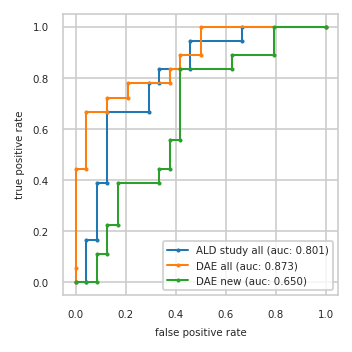

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.167   0.000 0.444   0.083 0.000
3          0.083 0.167   0.042 0.444   0.083 0.111
4          0.083 0.389   0.042 0.667   0.125 0.111
5          0.125 0.389   0.125 0.667   0.125 0.222
6          0.125 0.667   0.125 0.722   0.167 0.222
7          0.292 0.667   0.208 0.722   0.167 0.389
8          0.292 0.778   0.208 0.778   0.333 0.389
9          0.333 0.778   0.375 0.778   0.333 0.444
10         0.333 0.833   0.375 0.833   0.375 0.444
11         0.458 0.833   0.417 0.833   0.375 0.556
12         0.458 0.944   0.417 0.889   0.417 0.556
13         0.667 0.944   0.500 0.889   0.417 0.833
14         0.667 1.000   0.500 1.000   0.625 0.833
15         1.000 1.000   1.000 1.000   0.625 0.889
16           NaN   NaN     NaN   NaN   0.792 0.889
17           NaN   NaN     NaN   NaN   0.792 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q96GD0,P00568;Q5T9B7
2,P09486,Q9UM22,Q9NUQ9
3,K7ERG9;P00746,P63104,P31321
4,P14174,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P10636-2;P10636-6,Q14894,Q96GD0
6,P61981,P61981,P51688
7,P18428,P14174,Q9NZU1
8,Q9Y2T3;Q9Y2T3-3,P04075,P01704


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


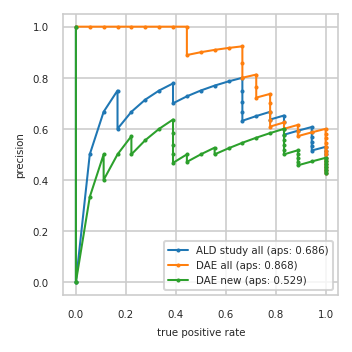

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.571 0.889     0.536 0.833
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.577 0.833     0.615 0.889     0.577 0.833
17         0.600 0.833     0.600 0.833     0.600 0.833
18         0.625 0.833     0.625 0.833     0.583 0.778
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.636 0.778     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.524 0.611
22         0.650 0.722     0.700 0.778     0.500 0.556
23         0.632 0.667     0.737 0.778     0.526 0.556
24         0.667 0.667     0.722 0.722     0.500 0.500
25         0.706 0.667     0.765 0.722     0.471 0.444
26         0.750 0.667     0.812 0.722     0.500 0.444
27         0.800 0.667     0.800 0.667     0.467 0.389
28         0.786 0.611     0.857 0.667     0.500 0.389
29         0.769 0.556     0.923 0.667     0.538 0.389
30         0.750 0.500     0.917 0.611     0.583 0.389
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.556 0.278
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.667 0.222     1.000 0.333     0.500 0.167
37         0.600 0.167     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


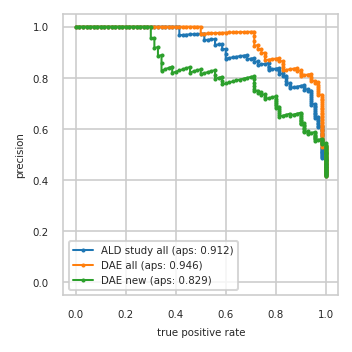

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


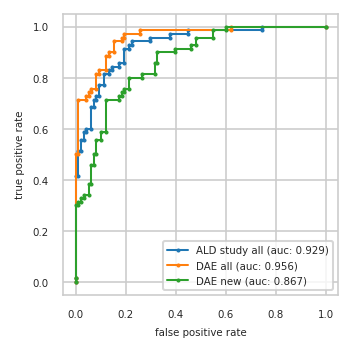

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}